# Exercise 1

*Coding:* Simulate a **FrugalGPT cascade**. Assume you have two models: A (cheap, 80% accuracy) and B (expensive, 90% accuracy). Define a simple confidence heuristic for model A (e.g. length of answer or presence of a certain keyword). Implement a policy that calls A, checks confidence; if confident, use A’s answer, if not, call B. Generate a dataset of queries with “ground truth” answers and simulate the cascade, measuring overall accuracy and cost. Compare this to always using B and always using A. Show how varying the confidence threshold produces a **Pareto curve of cost vs. accuracy**.

## Solution

Baselines:
nano only -> acc=0.780, cost=$0.000055, latency=4.29s
mini only -> acc=0.890, cost=$0.000221, latency=11.18s
Cascade (selected thresholds):
 threshold  accuracy  avg_cost  avg_latency_s  nano_accept_rate
       0.0      0.78  0.000055       4.294588              1.00
       0.5      0.89  0.000169      10.042972              0.49
       1.0      0.89  0.000267      15.035089              0.04


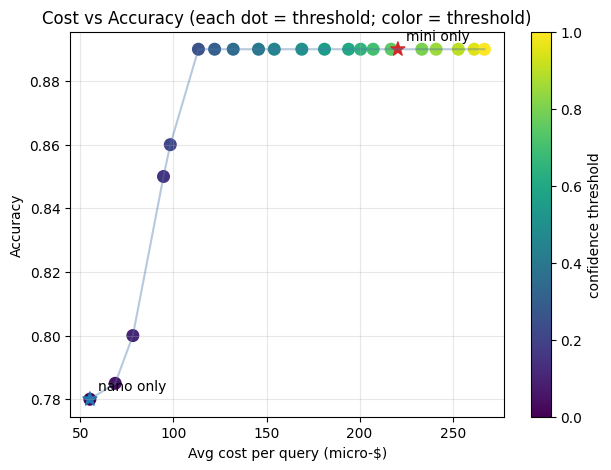

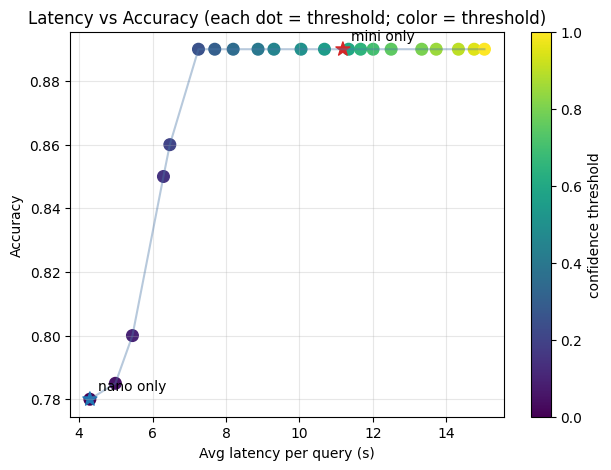

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)
N = 200

# OpenRouter pricing (USD per 1M tokens), base latency (s), and throughput (tokens/s).
pricing = {
    "nano": {"in": 0.10, "out": 0.40},
    "mini": {"in": 0.40, "out": 1.60},
}
base_latency_s = {"nano": 0.49, "mini": 0.51}
throughput_tps = {"nano": 77.81, "mini": 27.74}

# Synthetic dataset.
difficulty = rng.random(N)  # 0 = easy, 1 = hard
labels = rng.integers(0, 2, size=N)

prompt_tokens = rng.poisson(200, size=N) + 10
completion_tokens = rng.poisson(80, size=N) + 5
total_tokens = prompt_tokens + completion_tokens

# Confidence heuristic: easier queries yield higher confidence (proxy for clear/short queries).
confidence = np.clip(1 - difficulty + rng.normal(0, 0.05, size=N), 0, 1)

acc_nano, acc_mini = 0.80, 0.90

correct_nano = difficulty < acc_nano
correct_mini = difficulty < acc_mini

pred_nano = np.where(correct_nano, labels, 1 - labels)
pred_mini = np.where(correct_mini, labels, 1 - labels)

def cost_per_query(model):
    p = pricing[model]
    return (prompt_tokens * p["in"] + completion_tokens * p["out"]) / 1_000_000


def latency_per_query(model):
    return base_latency_s[model] + total_tokens / throughput_tps[model]

cost_nano = cost_per_query("nano")
cost_mini = cost_per_query("mini")

latency_nano = latency_per_query("nano")
latency_mini = latency_per_query("mini")

def run_cascade(threshold):
    use_nano = confidence >= threshold
    pred = np.where(use_nano, pred_nano, pred_mini)
    accuracy = (pred == labels).mean()
    avg_cost = (cost_nano + (~use_nano) * cost_mini).mean()
    avg_latency = (latency_nano + (~use_nano) * latency_mini).mean()
    use_nano_rate = use_nano.mean()
    return accuracy, avg_cost, avg_latency, use_nano_rate

thresholds = np.linspace(0, 1, 21)
rows = []
for t in thresholds:
    acc, avg_cost, avg_latency, use_nano_rate = run_cascade(t)
    rows.append({
        "threshold": round(float(t), 2),
        "accuracy": acc,
        "avg_cost": avg_cost,
        "avg_latency_s": avg_latency,
        "nano_accept_rate": use_nano_rate,
    })

results = pd.DataFrame(rows)

nano_acc = correct_nano.mean()
mini_acc = correct_mini.mean()
nano_cost = cost_nano.mean()
mini_cost = cost_mini.mean()
nano_latency = latency_nano.mean()
mini_latency = latency_mini.mean()

print("Baselines:")
print(f"nano only -> acc={nano_acc:.3f}, cost=${nano_cost:.6f}, latency={nano_latency:.2f}s")
print(f"mini only -> acc={mini_acc:.3f}, cost=${mini_cost:.6f}, latency={mini_latency:.2f}s")
print("Cascade (selected thresholds):")
print(results.loc[results["threshold"].isin([0.0, 0.5, 1.0])].to_string(index=False))

# Plot 1: cost vs accuracy (each point is a threshold).
plt.figure(figsize=(7, 5))
plt.scatter(results["avg_cost"] * 1e6, results["accuracy"],
            c=results["threshold"], cmap="viridis", s=70, label="cascade points")
plt.plot(results["avg_cost"] * 1e6, results["accuracy"], color="#4c78a8", alpha=0.4)
plt.scatter([nano_cost * 1e6, mini_cost * 1e6], [nano_acc, mini_acc],
            c=["#1f77b4", "#d62728"], s=110, marker="*")
plt.annotate("nano only", (nano_cost * 1e6, nano_acc), textcoords="offset points", xytext=(6, 6))
plt.annotate("mini only", (mini_cost * 1e6, mini_acc), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Avg cost per query (micro-$)")
plt.ylabel("Accuracy")
plt.title("Cost vs Accuracy (each dot = threshold; color = threshold)")
plt.grid(True, alpha=0.3)
cb = plt.colorbar()
cb.set_label("confidence threshold")
plt.show()

# Plot 2: latency vs accuracy (each point is a threshold).
plt.figure(figsize=(7, 5))
plt.scatter(results["avg_latency_s"], results["accuracy"],
            c=results["threshold"], cmap="viridis", s=70, label="cascade points")
plt.plot(results["avg_latency_s"], results["accuracy"], color="#4c78a8", alpha=0.4)
plt.scatter([nano_latency, mini_latency], [nano_acc, mini_acc],
            c=["#1f77b4", "#d62728"], s=110, marker="*")
plt.annotate("nano only", (nano_latency, nano_acc), textcoords="offset points", xytext=(6, 6))
plt.annotate("mini only", (mini_latency, mini_acc), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Avg latency per query (s)")
plt.ylabel("Accuracy")
plt.title("Latency vs Accuracy (each dot = threshold; color = threshold)")
plt.grid(True, alpha=0.3)
cb = plt.colorbar()
cb.set_label("confidence threshold")
plt.show()

